1

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

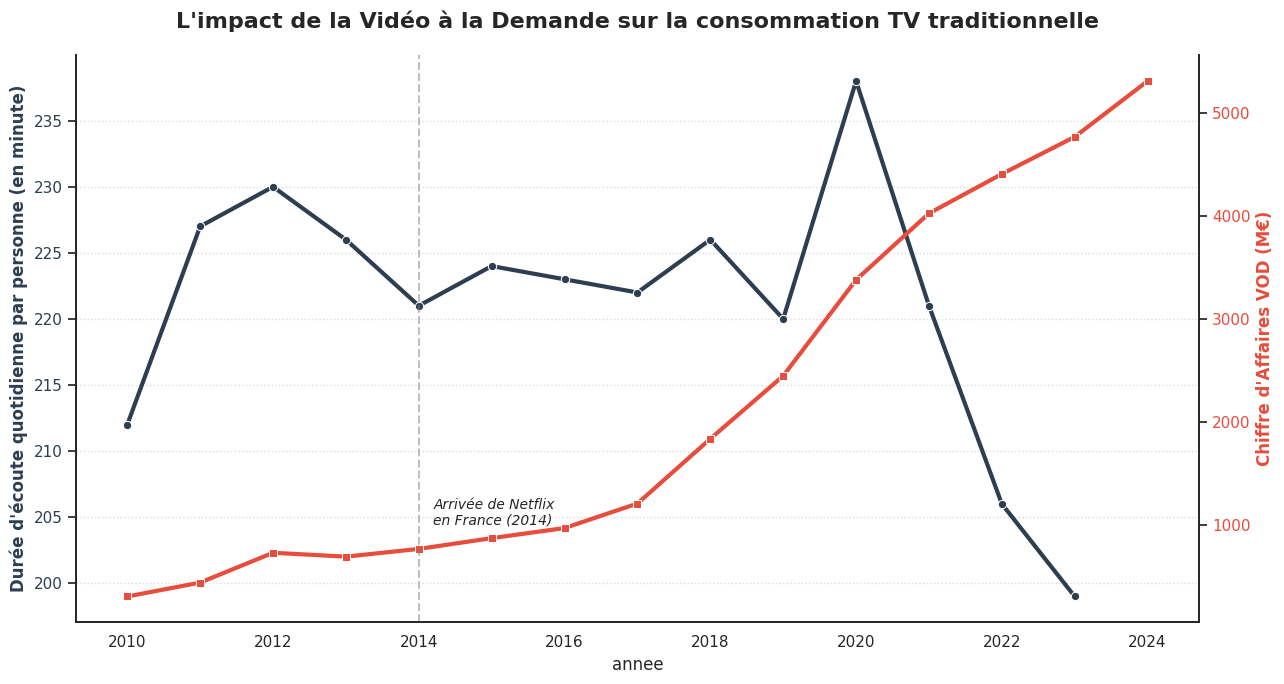

In [28]:
sns.set_theme(style="white") # Fond blanc propre
plt.rcParams['font.family'] = 'sans-serif'

# Préparation des données
df_subst = df[df['annee'] >= 2010].copy()

fig, ax1 = plt.subplots(figsize=(13, 7))

# --- COURBE 1 : Durée TV (Axe gauche) ---
color1 = '#2c3e50' # Bleu nuit élégant
sns.lineplot(data=df_subst, x='annee', y='duree_tv_globale_min',
             ax=ax1, color=color1, linewidth=3, marker='o', label='Consommation TV')
ax1.set_ylabel("Durée d'écoute quotidienne par personne (en minute)", fontsize=12, fontweight='bold', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# --- COURBE 2 : CA VaD (Axe droit) ---
ax2 = ax1.twinx()
color2 = '#e74c3c' # Rouge Netflix
sns.lineplot(data=df_subst, x='annee', y='ca_vad_millions',
             ax=ax2, color=color2, linewidth=3, marker='s', label='Revenus VaD')
ax2.set_ylabel('Chiffre d\'Affaires VOD (M€)', fontsize=12, fontweight='bold', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# --- ANNOTATION STRATÉGIQUE ---
# On marque l'arrivée de Netflix en France (2014)
plt.axvline(x=2014, color='gray', linestyle='--', alpha=0.5)
plt.text(2014.2, 1000, 'Arrivée de Netflix\nen France (2014)', fontsize=10, fontstyle='italic')

# --- ESTHÉTIQUE FINALE ---
plt.title("L'impact de la Vidéo à la Demande sur la consommation TV traditionnelle",
          fontsize=16, fontweight='bold', pad=20)
ax1.grid(True, axis='y', linestyle=':', alpha=0.7) # Grille légère uniquement horizontale
sns.despine(right=False) # Enlever les cadres inutiles
ax1.get_legend().remove()
ax2.get_legend().remove()

plt.tight_layout()
plt.show()

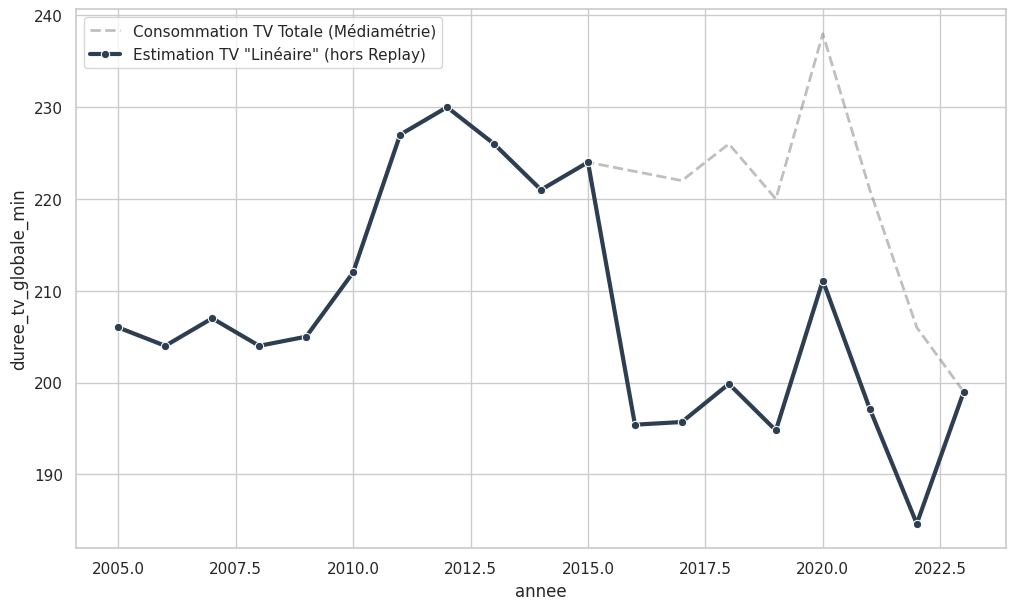

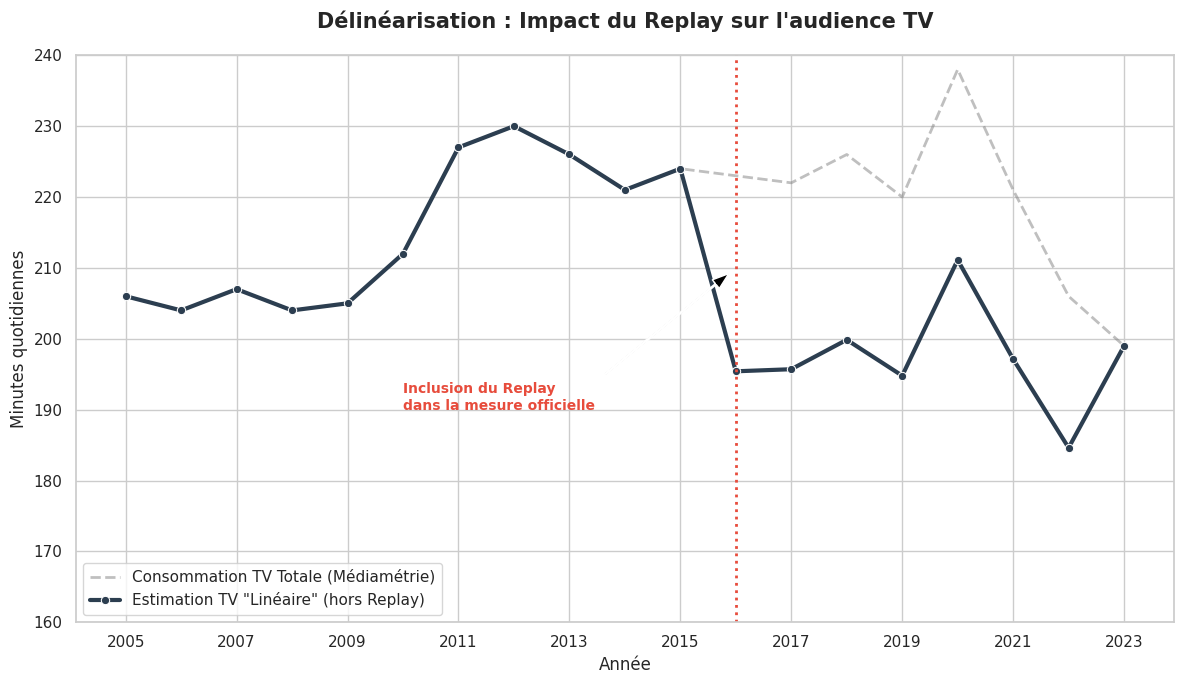

In [32]:

import numpy as np # Import pour gérer les paliers d'années

# On s'assure de recharger le fichier
df = pd.read_csv('data/processed/master_file_annuel.csv')
df['annee'] = df['annee'].astype(int)

# Fonction de calcul
def get_pure_linear(row):
    if 'taux_replay_pourcent' not in row or pd.isna(row['taux_replay_pourcent']):
        return row['duree_tv_globale_min']
    if row['annee'] >= 2016:
        correction = (row['taux_replay_pourcent'] / 100) * 0.15
        return row['duree_tv_globale_min'] * (1 - correction)
    return row['duree_tv_globale_min']

df['duree_tv_lineaire_pure'] = df.apply(get_pure_linear, axis=1)

# --- VISUALISATION ---
plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

# Courbes
sns.lineplot(data=df[df['annee'] >= 2005], x='annee', y='duree_tv_globale_min',
             label='Consommation TV Totale (Médiamétrie)',
             color='gray', linestyle='--', alpha=0.5, linewidth=2)

sns.lineplot(data=df[df['annee'] >= 2005], x='annee', y='duree_tv_lineaire_pure',
             label='Estimation TV "Linéaire" (hors Replay)',
             color='#2c3e50', linewidth=3, marker='o')

# --- RÉGLAGE DE L'AXE X (ANNÉES ENTIÈRES) ---
years = df[df['annee'] >= 2005]['annee'].unique()
# On affiche une graduation tous les 2 ans pour éviter que ce soit illisible
plt.xticks(np.arange(min(years), max(years) + 1, 2))

# --- ANNOTATIONS ET STYLE ---
plt.axvline(x=2016, color='#e74c3c', linestyle=':', linewidth=2)
plt.annotate('Inclusion du Replay\ndans la mesure officielle',
             xy=(2016, 210), xytext=(2010, 190),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
             fontsize=10, color='#e74c3c', fontweight='bold')

plt.title("Impact du Replay sur l'audience TV", fontsize=15, pad=20, fontweight='bold')
plt.ylabel("Minutes quotidiennes", fontsize=12)
plt.xlabel("Année", fontsize=12)
plt.legend(loc='lower left', frameon=True, facecolor='white')
plt.ylim(160, 240)

plt.tight_layout()
plt.show()

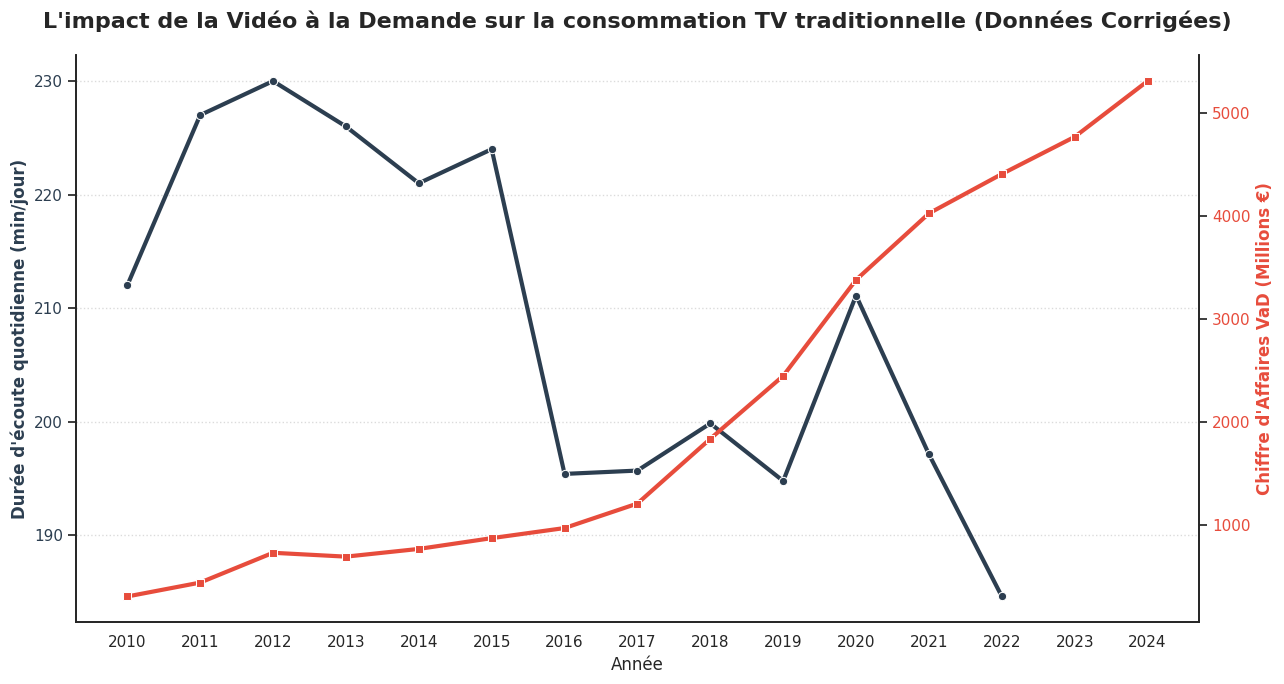

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- CONFIGURATION DU STYLE ---
sns.set_theme(style="white") # Fond blanc propre
plt.rcParams['font.family'] = 'sans-serif'

# 1. Chargement (assure-toi que le chemin est correct)
df = pd.read_csv('data/processed/master_file_annuel.csv')

# 2. Définition de la fonction de correction
def get_pure_linear(row):
    if row['annee'] >= 2016:
        # On retire l'impact du Replay (environ 15% du temps pour les utilisateurs du replay)
        correction = (row['taux_replay_pourcent'] / 100) * 0.15
        return row['duree_tv_globale_min'] * (1 - correction)
    return row['duree_tv_globale_min']

# 3. CRÉATION DE LA COLONNE
df['duree_tv_lineaire_pure'] = df.apply(get_pure_linear, axis=1)

# 4. CRÉATION DE LA COPIE FILTRÉE
df_subst = df[df['annee'] >= 2010].copy()

# 5. GÉNÉRATION DU GRAPHIQUE
fig, ax1 = plt.subplots(figsize=(13, 7))

# Couleurs identiques au premier graphique
color1 = '#2c3e50' # Bleu nuit élégant
color2 = '#e74c3c' # Rouge Netflix

# --- COURBE 1 : Durée TV Linéaire Pure (Axe gauche) ---
sns.lineplot(data=df_subst, x='annee', y='duree_tv_lineaire_pure',
             ax=ax1, color=color1, linewidth=3, marker='o', label='Durée TV Linéaire Pure')

ax1.set_ylabel("Durée d'écoute quotidienne (min/jour)", fontsize=12, fontweight='bold', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlabel('Année', fontsize=12)

# --- COURBE 2 : CA VaD (Axe droit) ---
ax2 = ax1.twinx()
sns.lineplot(data=df_subst, x='annee', y='ca_vad_millions',
             ax=ax2, color=color2, linewidth=3, marker='s', label='CA VaD (M€)')

ax2.set_ylabel("Chiffre d'Affaires VaD (Millions €)", fontsize=12, fontweight='bold', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# --- RÉGLAGE DE L'AXE X (ANNÉES ENTIÈRES) ---
years = df_subst['annee'].astype(int).unique()
ax1.set_xticks(np.arange(min(years), max(years) + 1, 1))

# --- ESTHÉTIQUE FINALE ---
plt.title("L'impact de la Vidéo à la Demande sur la consommation TV traditionnelle (Données Corrigées)",
          fontsize=16, fontweight='bold', pad=20)

ax1.grid(True, axis='y', linestyle=':', alpha=0.7) # Grille légère horizontale
sns.despine(right=False) # Enlever les cadres inutiles
ax1.get_legend().remove()
ax2.get_legend().remove()


plt.tight_layout()
plt.show()

In [51]:
df_reg = df[df['annee'] >= 2010].dropna(subset=['duree_tv_lineaire_pure', 'ca_vad_millions'])

Y = df_reg['duree_tv_lineaire_pure']
X = df_reg[['ca_vad_millions', 'taux_replay_pourcent']]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

# 4. Affichage des résultats
print("--- RÉSULTATS DE LA RÉGRESSION (TV LINÉAIRE CORRIGÉE) ---")
print(model.summary())

--- RÉSULTATS DE LA RÉGRESSION (TV LINÉAIRE CORRIGÉE) ---
                              OLS Regression Results                              
Dep. Variable:     duree_tv_lineaire_pure   R-squared:                       0.532
Model:                                OLS   Adj. R-squared:                  0.439
Method:                     Least Squares   F-statistic:                     5.690
Date:                    Wed, 14 Jan 2026   Prob (F-statistic):             0.0224
Time:                            10:03:20   Log-Likelihood:                -48.428
No. Observations:                      13   AIC:                             102.9
Df Residuals:                          10   BIC:                             104.6
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

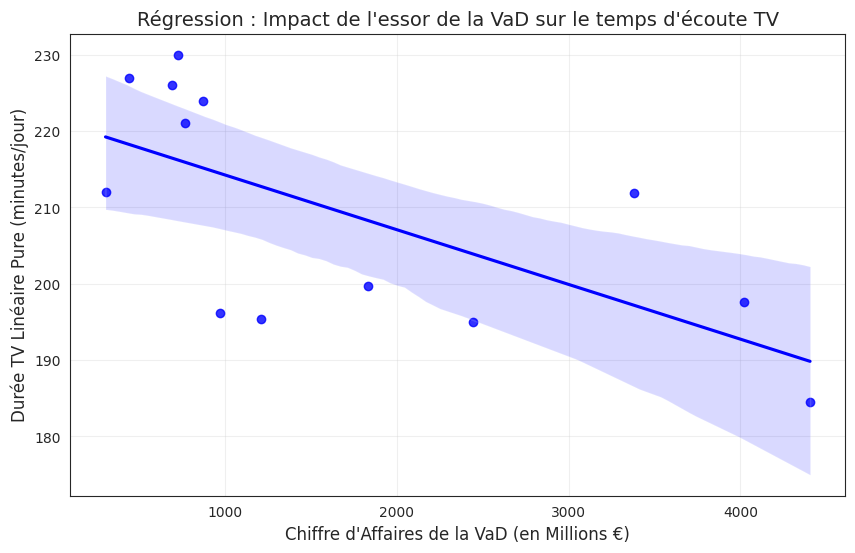

In [52]:
df_plot = df_reg.dropna(subset=['duree_tv_lineaire_pure', 'ca_vad_millions']).copy()

# 2. Création du graphique
plt.figure(figsize=(10, 6))


# On trace la droite de régression
sns.regplot(data=df_plot, x='ca_vad_millions', y='duree_tv_lineaire_pure',
            scatter=True, color='blue', label='Tendance (Régression)')

# Habillage
plt.title("Régression : Impact de l'essor de la VaD sur le temps d'écoute TV", fontsize=14)
plt.xlabel("Chiffre d'Affaires de la VaD (en Millions €)", fontsize=12)
plt.ylabel("Durée TV Linéaire Pure (minutes/jour)", fontsize=12)

# Annotation du coefficient
coef_vad = model.params['ca_vad_millions']


plt.grid(True, alpha=0.3)
plt.show()

2

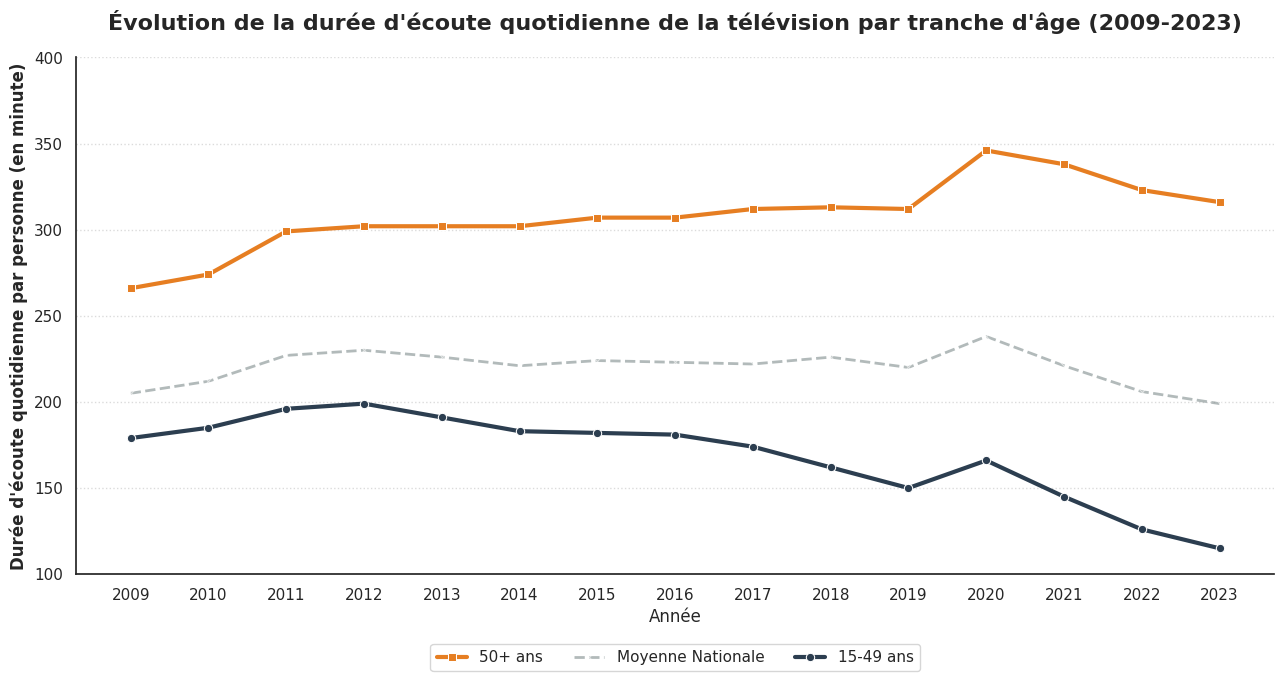

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- CONFIGURATION DU STYLE ---
sns.set_theme(style="white") # Fond blanc propre
plt.rcParams['font.family'] = 'sans-serif'

# 1. Chargement et filtrage
df = pd.read_csv('data/processed/master_file_annuel.csv')
df['annee'] = df['annee'].astype(int)
df_periode = df[(df['annee'] >= 2009) & (df['annee'] <= 2023)].copy()

# 2. GÉNÉRATION DU GRAPHIQUE
fig, ax = plt.subplots(figsize=(13, 7))

# Définition des couleurs pour la cohérence
color_seniors = '#e67e22' # Orange (fidélité)
color_moyenne = '#7f8c8d' # Gris (neutre)
color_actifs = '#2c3e50'  # Bleu nuit (décrochage)

# --- COURBE 1 : Les Seniors (50+ ans) ---
sns.lineplot(data=df_periode, x='annee', y='duree_tv_50_plus_min',
             ax=ax, color=color_seniors, linewidth=3, marker='s', label='50+ ans')

# --- COURBE 2 : Moyenne Nationale ---
sns.lineplot(data=df_periode, x='annee', y='duree_tv_globale_min',
             ax=ax, color=color_moyenne, linewidth=2, linestyle='--', marker='x',
             alpha=0.6, label='Moyenne Nationale')

# --- COURBE 3 : Les Actifs (15-49 ans) ---
sns.lineplot(data=df_periode, x='annee', y='duree_tv_15_49_min',
             ax=ax, color=color_actifs, linewidth=3, marker='o', label='15-49 ans')

# --- RÉGLAGE DE L'AXE X (ANNÉES ENTIÈRES) ---
years = df_periode['annee'].unique()
ax.set_xticks(np.arange(min(years), max(years) + 1, 1))

# --- ESTHÉTIQUE FINALE ---
plt.title("Évolution de la durée d'écoute quotidienne de la télévision par tranche d'âge (2009-2023)",
          fontsize=16, fontweight='bold', pad=20)

ax.set_ylabel("Durée d'écoute quotidienne par personne (en minute)", fontsize=12, fontweight='bold')
ax.set_xlabel('Année', fontsize=12)

ax.grid(True, axis='y', linestyle=':', alpha=0.7) # Grille légère horizontale
sns.despine() # Enlever les bordures inutiles

# Ajustement de la limite Y pour la lisibilité
ax.set_ylim(100, 400)

# Légende élégante en bas
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3, frameon=True)



plt.tight_layout()
plt.show()

In [8]:
df = pd.read_csv('data/processed/master_file_annuel.csv')
# On filtre sur la période où la VaD existe (2010+) et où les données sont complètes
df_reg = df[df['annee'] >= 2010].dropna(subset=['ca_vad_millions', 'duree_tv_15_49_min', 'duree_tv_50_plus_min'])

X = sm.add_constant(df_reg[['ca_vad_millions', 'offre_fiction_pourcent']])

# Modèle 1 : Les 15-49 ans (Cible commerciale / Digitale)
model_jeunes = sm.OLS(df_reg['duree_tv_15_49_min'], X).fit()

# Modèle 2 : Les 50+ (Cible historique / Résiliente)
model_vieux = sm.OLS(df_reg['duree_tv_50_plus_min'], X).fit()

print("=== IMPACT DE LA VAD : JEUNES (15-49) VS VIEUX (50+) ===")
print(model_jeunes.summary())
print(model_vieux.summary())

=== IMPACT DE LA VAD : JEUNES (15-49) VS VIEUX (50+) ===
                            OLS Regression Results                            
Dep. Variable:     duree_tv_15_49_min   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     43.78
Date:                Thu, 15 Jan 2026   Prob (F-statistic):           5.79e-06
Time:                        01:42:49   Log-Likelihood:                -49.504
No. Observations:                  14   AIC:                             105.0
Df Residuals:                      11   BIC:                             106.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

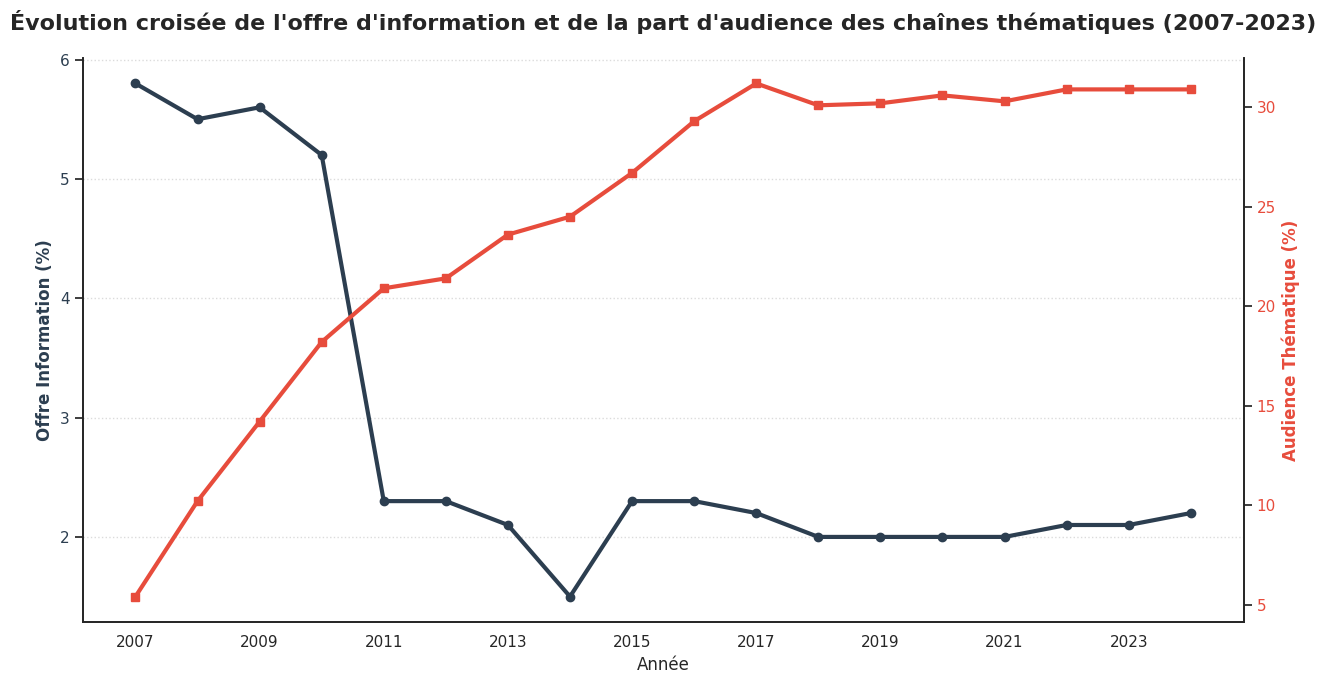

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- CONFIGURATION DU STYLE ---
sns.set_theme(style="white")
plt.rcParams['font.family'] = 'sans-serif'
color_info = '#2c3e50' # Bleu nuit (Offre)
color_them = '#e74c3c' # Rouge (Audience)

# 1. Préparation des données
df = pd.read_csv('data/processed/master_file_annuel.csv')
df_plot = df.dropna(subset=['offre_info_pourcent', 'pda_thematiques']).copy()
df_plot['annee'] = df_plot['annee'].astype(int)

# --- GÉNÉRATION DU GRAPHIQUE TEMPOREL ---
fig, ax1 = plt.subplots(figsize=(13, 7))

# Courbe 1 : Offre Information (Axe gauche)
ax1.plot(df_plot['annee'], df_plot['offre_info_pourcent'],
         color=color_info, marker='o', linewidth=3, label="Part de l'Information (%)")
ax1.set_xlabel('Année', fontsize=12)
ax1.set_ylabel('Offre Information (%)', color=color_info, fontweight='bold', fontsize=12)
ax1.tick_params(axis='y', labelcolor=color_info)

# Courbe 2 : Audience Thématique (Axe droit)
ax2 = ax1.twinx()
ax2.plot(df_plot['annee'], df_plot['pda_thematiques'],
         color=color_them, marker='s', linewidth=3, label="PDA Thématiques (%)")
ax2.set_ylabel('Audience Thématique (%)', color=color_them, fontweight='bold', fontsize=12)
ax2.tick_params(axis='y', labelcolor=color_them)

# Titre et Grille
plt.title("Évolution croisée de l'offre d'information et de la part d'audience des chaînes thématiques (2007-2024)",
          fontsize=16, fontweight='bold', pad=20)
ax1.grid(True, axis='y', linestyle=':', alpha=0.7)

# Réglage de l'axe X (Années entières tous les 2 ans)
ax1.set_xticks(np.arange(df_plot['annee'].min(), df_plot['annee'].max() + 1, 2))

# Esthétique finale
sns.despine(right=False) # On garde la bordure droite pour l'axe rouge


plt.tight_layout()
plt.show()

--- RÉSULTATS DE LA RÉGRESSION : STRATÉGIE INFO ---
                            OLS Regression Results                            
Dep. Variable:        pda_thematiques   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     96.78
Date:                Wed, 14 Jan 2026   Prob (F-statistic):           2.34e-10
Time:                        17:23:15   Log-Likelihood:                -45.494
No. Observations:                  21   AIC:                             96.99
Df Residuals:                      18   BIC:                             100.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

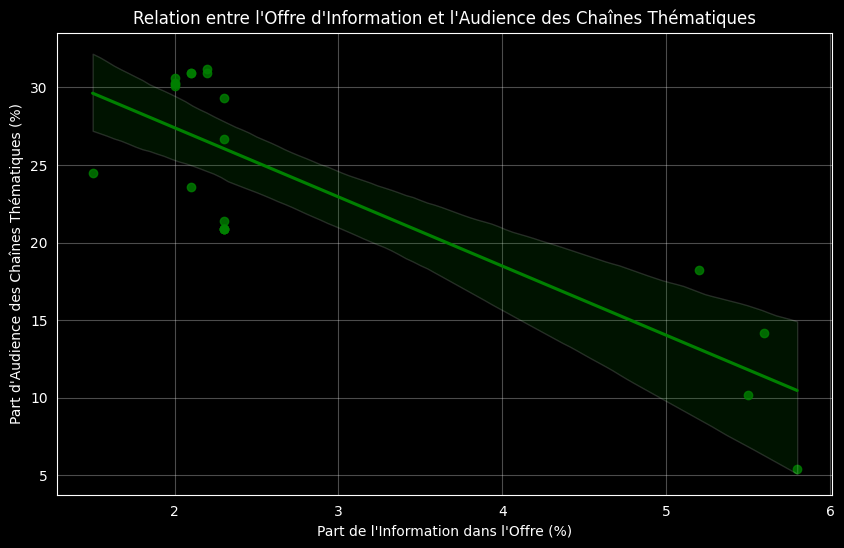

In [13]:
df = pd.read_csv('data/processed/master_file_annuel.csv')

# On filtre les années où nous avons à la fois l'offre info et la PDA
# Généralement pertinent à partir de l'arrivée de la TNT (2005+)
df_strat = df.dropna(subset=['pda_thematiques', 'offre_info_pourcent'])

# 2. Définition des variables
# Y = Part d'audience des chaînes thématiques/info (Demande)
# X = Offre d'information en % du volume horaire (Offre)
Y = df_strat['pda_thematiques']
X = df_strat[['offre_info_pourcent', 'annee']] # On ajoute l'année pour contrôler l'effet temps
X = sm.add_constant(X)

# 3. Exécution du modèle OLS
model_strat = sm.OLS(Y, X).fit()

# 4. Affichage des résultats
print("--- RÉSULTATS DE LA RÉGRESSION : STRATÉGIE INFO ---")
print(model_strat.summary())

# 5. Visualisation de la corrélation
plt.figure(figsize=(10, 6))
sns.regplot(x='offre_info_pourcent', y='pda_thematiques', data=df_strat, color='green')
plt.title('Relation entre l\'Offre d\'Information et l\'Audience des Chaînes Thématiques')
plt.xlabel('Part de l\'Information dans l\'Offre (%)')
plt.ylabel('Part d\'Audience des Chaînes Thématiques (%)')
plt.grid(True, alpha=0.3)
plt.show()

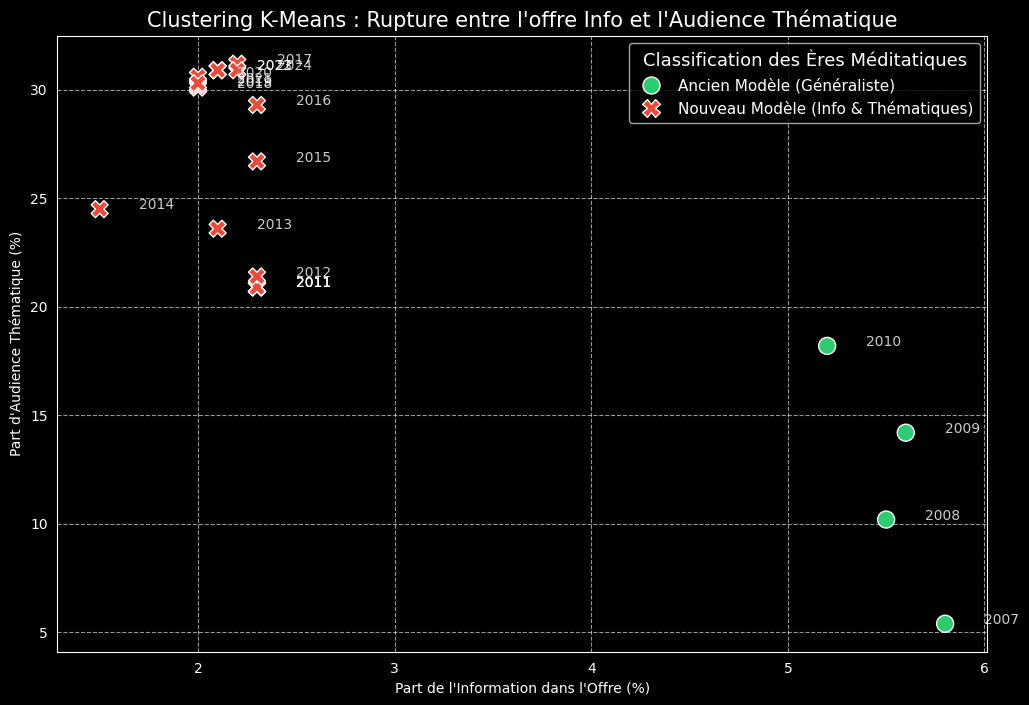

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. On nettoie pour n'avoir que les lignes avec nos deux variables
df_ml = df.dropna(subset=['offre_info_pourcent', 'pda_thematiques']).copy()

# 2. Préparation des données (X = Offre, Y = Audience)
X = df_ml[['offre_info_pourcent', 'pda_thematiques']]

# Normalisation : indispensable car les échelles peuvent différer
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. K-Means avec 2 clusters (les deux zones que tu as repérées)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df_ml['cluster'] = kmeans.fit_predict(X_scaled)

noms_clusters = {
    0: "Ancien Modèle (Généraliste)",
    1: "Nouveau Modèle (Info & Thématiques)"
}

# 2. On applique ces noms à une nouvelle colonne
df_ml['Nom_Era'] = df_ml['cluster'].map(noms_clusters)

# 3. On trace le graphique avec Seaborn en utilisant 'Nom_Era'
plt.figure(figsize=(12, 8))

plot = sns.scatterplot(
    data=df_ml,
    x='offre_info_pourcent',
    y='pda_thematiques',
    hue='Nom_Era',      # On utilise la colonne avec les vrais noms
    palette=['#2ecc71', '#e74c3c'], # Vert et Rouge pour bien marquer le contraste
    s=150,Grand Remplacemen
    style='Nom_Era'
)

# On ajoute les années pour la clarté
for i in range(df_ml.shape[0]):
    plt.text(df_ml.offre_info_pourcent.iloc[i]+0.2, df_ml.pda_thematiques.iloc[i],
             int(df_ml.annee.iloc[i]), fontsize=10, alpha=0.8)

# Personnalisation de la légende
plt.legend(title="Classification des Ères Méditatiques", title_fontsize='13', fontsize='11')
plt.title("Clustering K-Means : Rupture entre l'offre Info et l'Audience Thématique", fontsize=15)
plt.xlabel("Part de l'Information dans l'Offre (%)")
plt.ylabel("Part d'Audience Thématique (%)")
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()